In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Read the Data

In [2]:
# Read in our .csv 
FILENAME = "doge-usd-max.csv"
dataframe = pd.read_csv(os.path.join("..", "assets", FILENAME))
#header_df = pd.read_csv("assets/doge-usd-max.csv", nrows=0)

# VALUEs we need based on the header of the .csv file.
VALUE = "price"
TIMESTAMP = "snapped_at"

# Create "new" df based on TIMESTAMP and VALUE.
df = dataframe[[TIMESTAMP, VALUE]].copy()
df[TIMESTAMP] = pd.to_datetime(df[TIMESTAMP], format='%Y-%m-%d %H:%M:%S %Z').dt.tz_localize(None)

### Plot Data

Start date is:  2013-12-15 00:00:00
End date is:  2024-08-22 00:00:00
Dodgecoin Low:  8.690375727008734e-05
Dodgecoin High:  0.6818416367796407


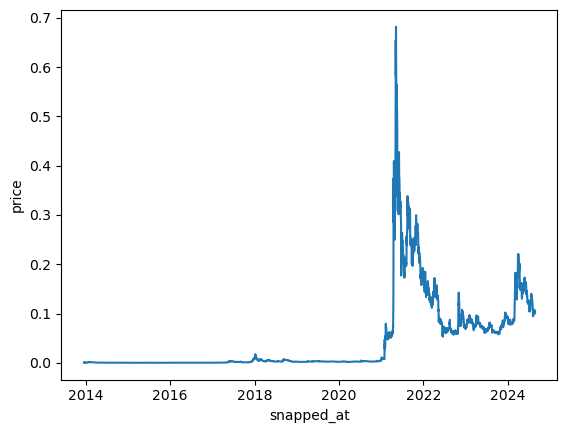

In [3]:
sns.lineplot(x = df[TIMESTAMP], y = df[VALUE])

print("Start date is: ", df[TIMESTAMP].min())
print("End date is: ", df[TIMESTAMP].max())

print("Dodgecoin Low: ", df[VALUE].min())
print("Dodgecoin High: ", df[VALUE].max())


### Split data into test and train

<Axes: xlabel='snapped_at', ylabel='price'>

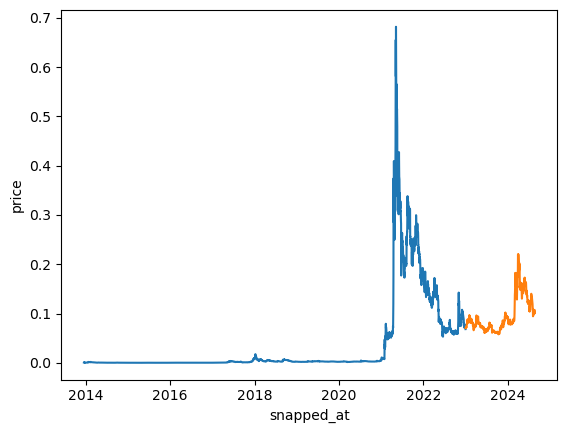

In [5]:
train = df.loc[df[TIMESTAMP] <= '2022-12-31']
test = df.loc[df[TIMESTAMP] > '2022-12-31']

sns.lineplot(x = train[TIMESTAMP], y = train[VALUE])
sns.lineplot(x = test[TIMESTAMP], y = test[VALUE])


/var/folders/4t/kg_b2_255mx14bkn7cnmt0pc0000gn/T/ipykernel_37575/1346547125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[VALUE] = scaler.transform(train[[VALUE]])
/var/folders/4t/kg_b2_255mx14bkn7cnmt0pc0000gn/T/ipykernel_37575/1346547125.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[VALUE] = scaler.transform(test[[VALUE]])


<Axes: xlabel='snapped_at', ylabel='price'>

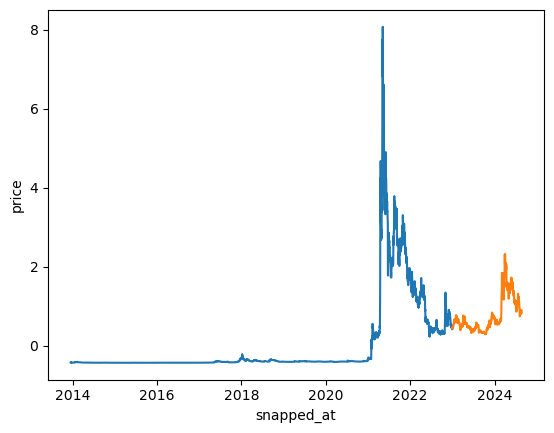

In [7]:
scaler = StandardScaler()
scaler = scaler.fit(train[[VALUE]])

train[VALUE] = scaler.transform(train[[VALUE]])
test[VALUE] = scaler.transform(test[[VALUE]])

#sns.lineplot(x = train[TIMESTAMP], y = train[VALUE])
#sns.lineplot(x = test[TIMESTAMP], y = test[VALUE])



In [8]:
# Number of time step to look back.
seq_size = 30

def toSequences(x, y, seq_size = 1):
    x_values  = []
    y_values = []

    for i in range(len(x) - seq_size):
        x_values.append(x.iloc[i : i + seq_size].values)
        y_values.append(y.iloc[i : i + seq_size])
    
    return np.array(x_values), np.array(y_values)

trainX, trainY = toSequences(train[[VALUE]], train[VALUE], seq_size)
testX, testY = toSequences(test[[VALUE]], test[VALUE], seq_size)



In [11]:
model = Sequential()
model.add(LSTM(128, input_shape= (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate = 0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences = True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer="adam", loss="mae")
model.summary()

         

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

2024-08-27 19:35:00.494107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-27 19:35:00.494514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-27 19:35:00.494938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-08-27 19:38:50.776592: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-08-27 19:38:50.911517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-27 19:38:50.911929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-27 19:38:50.912288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

91/92 [============================>.] - ETA: 0s - loss: 0.1368

2024-08-27 19:38:53.943619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-27 19:38:53.944145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-27 19:38:53.944479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

92/92 [==============================] - 3s 26ms/step - loss: 0.1360 - val_loss: 0.2248
Epoch 2/100
92/92 [==============================] - 2s 24ms/step - loss: 0.0918 - val_loss: 0.1737
Epoch 3/100
92/92 [==============================] - 2s 24ms/step - loss: 0.0847 - val_loss: 0.2118
Epoch 4/100
92/92 [==============================] - 2s 24ms/step - loss: 0.0774 - val_loss: 0.1201
Epoch 5/100
92/92 [==============================] - 2s 24ms/step - loss: 0.0739 - val_loss: 0.1413
Epoch 6/100
92/92 [==============================] - 2s 24ms/step - loss: 0.0755 - val_loss: 0.1346
Epoch 7/100
92/92 [==============================] - 2s 24ms/step - loss: 0.0732 - val_loss: 0.1249
Epoch 8/100
92/92 [==============================] - 2s 24ms/step - loss: 0.0689 - val_loss: 0.1285
Epoch 9/100
92/92 [==============================] - 2s 24ms/step - loss: 0.0649 - val_loss: 0.1734
Epoch 10/100
92/92 [==============================] - 2s 24ms/step - loss: 0.0631 - val_loss: 0.1446
Epoch 11/10

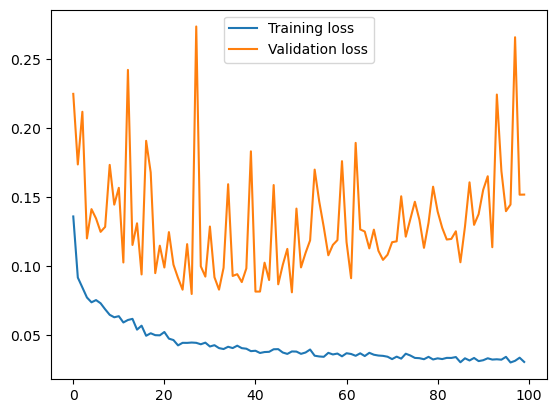

In [12]:
# Fit Model

history = model.fit(trainX, trainY, epochs=100, batch_size=32,validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

  1/103 [..............................] - ETA: 23s

2024-08-27 19:43:49.212446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-27 19:43:49.213126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-27 19:43:49.213537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

103/103 [==============================] - 1s 6ms/step


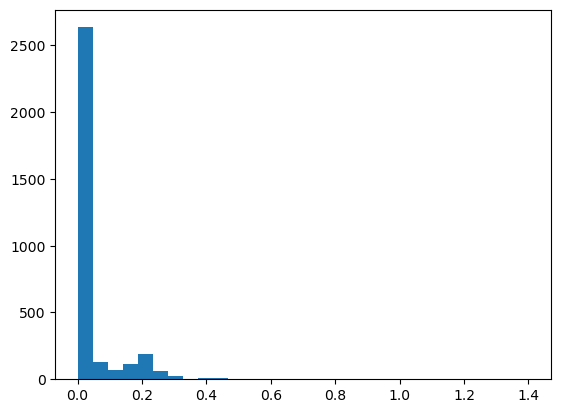

In [13]:
train_predict = model.predict(trainX)
trainMAE = np.mean(np.abs(train_predict - trainX), axis = 1)
plt.hist(trainMAE, bins = 30)
max_trainMAE = 0.3

18/18 [==============================] - 0s 6ms/step


(array([38., 22., 37., 13., 22., 15., 45., 18., 18., 18., 22., 57., 28.,
        28., 43., 23., 16., 18., 19., 17., 10., 11.,  5., 11.,  4.,  1.,
         1.,  1.,  6.,  3.]),
 array([0.03807224, 0.04768722, 0.05730219, 0.06691717, 0.07653214,
        0.08614712, 0.0957621 , 0.10537707, 0.11499205, 0.12460702,
        0.134222  , 0.14383698, 0.15345195, 0.16306693, 0.1726819 ,
        0.18229688, 0.19191186, 0.20152683, 0.21114181, 0.22075678,
        0.23037176, 0.23998673, 0.24960171, 0.25921669, 0.26883166,
        0.27844664, 0.28806161, 0.29767659, 0.30729157, 0.31690654,
        0.32652152]),
 <BarContainer object of 30 artists>)

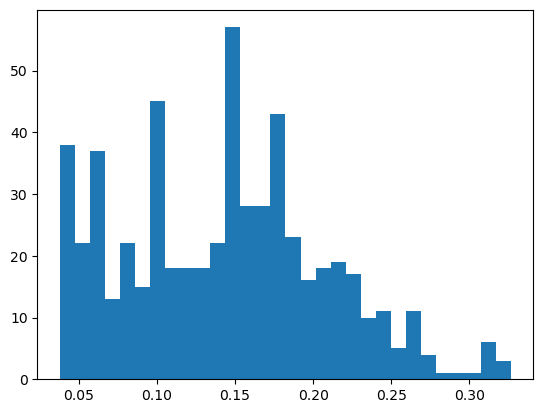

In [14]:
test_predict = model.predict(testX)
testMAE = np.mean(np.abs(test_predict - testX), axis = 1)
plt.hist(testMAE, bins = 30)

In [15]:
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df["testMAE"] = testMAE
anomaly_df["max_trainMAE"] = max_trainMAE
anomaly_df["anomaly"] = anomaly_df["testMAE"] > anomaly_df["max_trainMAE"]
anomaly_df[VALUE] = test[seq_size:][VALUE] 

<Axes: xlabel='snapped_at', ylabel='testMAE'>

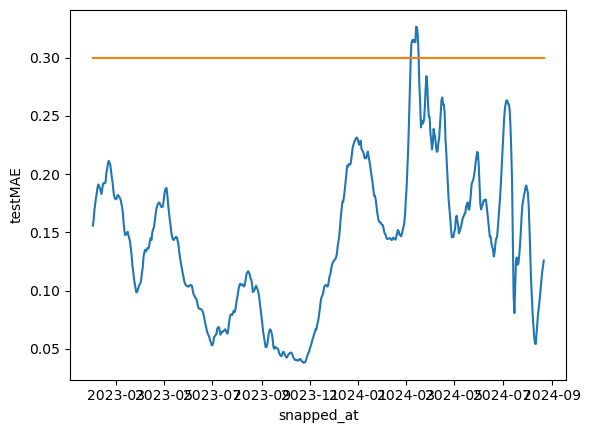

In [16]:
sns.lineplot(x=anomaly_df[TIMESTAMP], y=anomaly_df["testMAE"])
sns.lineplot(x=anomaly_df[TIMESTAMP], y=anomaly_df["max_trainMAE"])

In [17]:
anomalies = anomaly_df.loc[anomaly_df["anomaly"] == True]



<Axes: xlabel='snapped_at'>

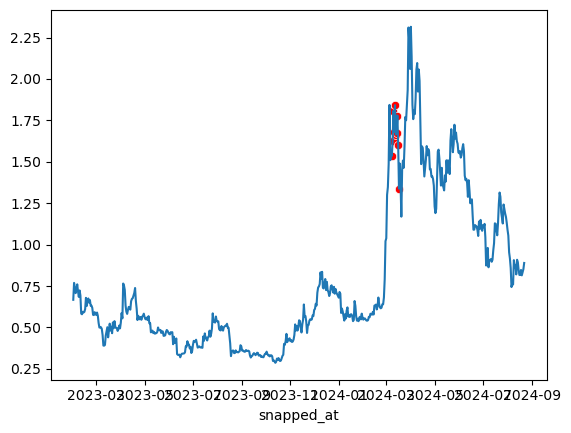

In [23]:
# sns.lineplot(x=anomaly_df[TIMESTAMP], y=scaler.inverse_transform(anomaly_df[VALUE]))
# sns.scatterplot(x=anomalies[TIMESTAMP], y=scaler.inverse_transform(anomalies[VALUE]), color='r')

# Reshape the series to be 2D
y_values = anomaly_df[VALUE].values.reshape(-1, 1)
anomalies_y_values = anomalies[VALUE].values.reshape(-1, 1)

# Plot using the reshaped data
sns.lineplot(x=anomaly_df[TIMESTAMP], y=scaler.inverse_transform(y_values).flatten())
sns.scatterplot(x=anomalies[TIMESTAMP], y=scaler.inverse_transform(anomalies_y_values).flatten(), color='r')
